# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [5]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 66.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=4adc2be5c23b5adb4383301747e01b501bbd15da63201cb40f1e21719d3f7edf
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [6]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [7]:
!gdown --id 1GlqW-889y-JW7t6WaqMANRawKCc4Hre9

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GlqW-889y-JW7t6WaqMANRawKCc4Hre9
To: /content/mini_sparkify_event_data.json
100% 128M/128M [00:00<00:00, 171MB/s]


In [8]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime
import time

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, when
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.mllib.evaluation import BinaryClassificationMetrics

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Normalizer, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

import re

In [9]:
# create a Spark session
spark = SparkSession.builder\
    .appName("Sparkify Analysis")\
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

**Load data**

In [10]:
# Load JSON Event data
df = spark.read.json('./mini_sparkify_event_data.json')

In [11]:
print(f'Dataframe shape: ({df.count()}, {len(df.columns)})')

Dataframe shape: (286500, 18)


In [12]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [13]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [14]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

In [15]:
df.toPandas().isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

**Clean data**

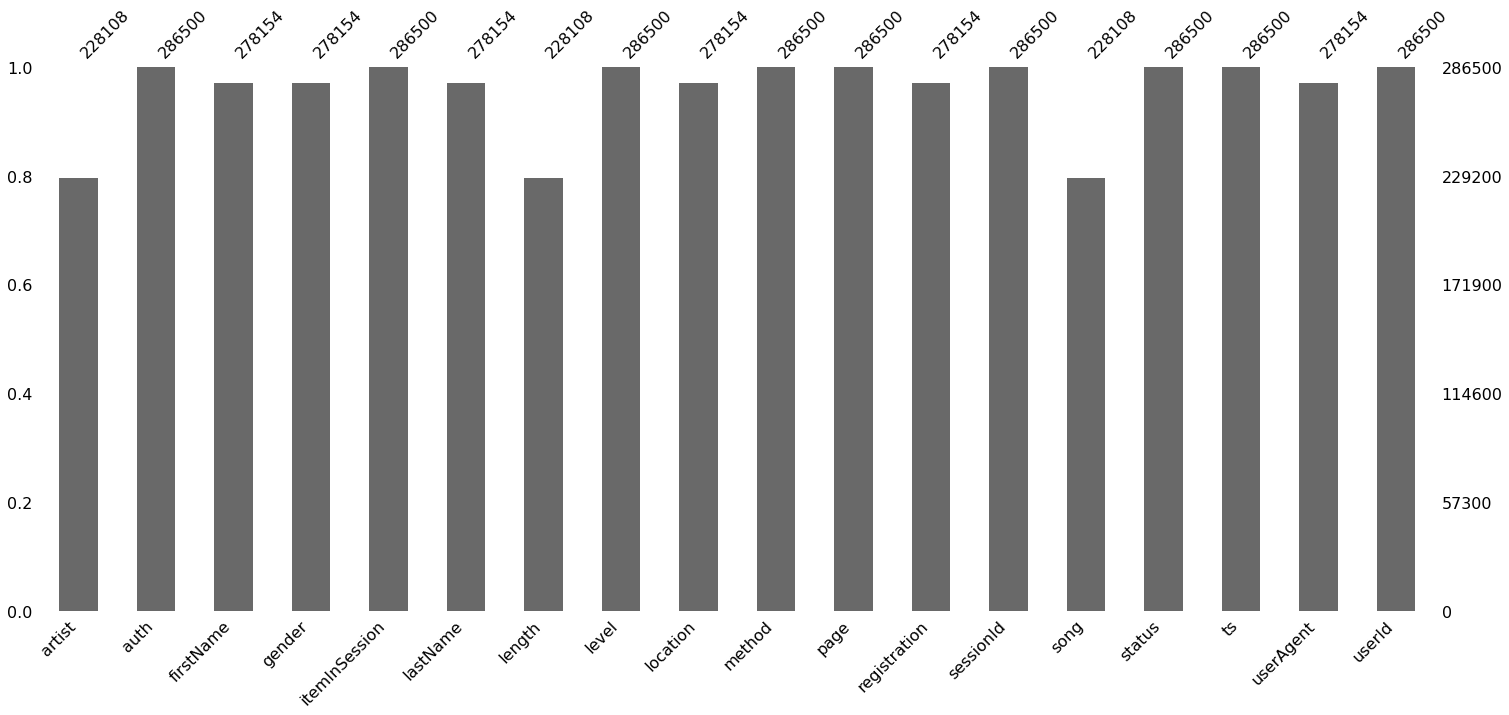

In [16]:
# Using missingno package to visualize missing values in data
msno.bar(df.toPandas())

I will drop records that do not have `userId` or `sessionId`

In [17]:
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

Check and drop if exists empty string values in `userId` columns

In [18]:
df.filter(df.userId == "").count()

8346

In [19]:
df = df.filter(df.userId != "")

In [20]:
df.count()

278154

After cleaning missing values and invalid values, there is 278154 records remaining in the dataset.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

>I defined churn as people who cancelled Sparkify. To check this, I used the `page` columns in data to check for 'Cancellation Confirmation' page appeared. If exists, that is churned user.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [21]:
# Number of users who churned
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

I create the flag for churned users by a ssigning a 1 if a user has been churned and a 0 if they have not. This flag will be used to create a new column named `churn`, which will be used as the Target Column for later Modelling stage.

In [22]:
# Define a User Define Function to flag 1's and 0's 

churn_flag_function = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [23]:
# Create `churn` column
df = df.withColumn("churn", churn_flag_function("page"))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

Now I will sort records for `userId` in reverse time order and add up the values in the `churn` column.

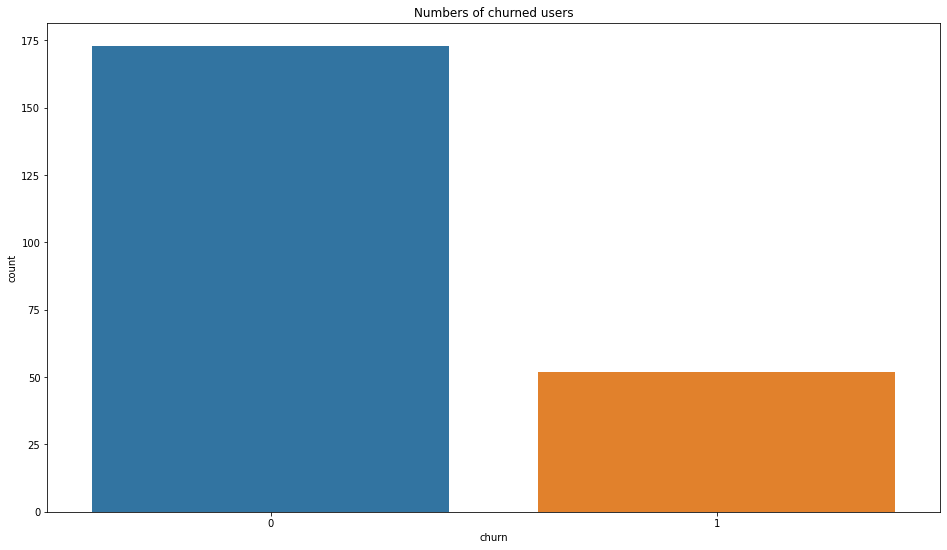

In [24]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn", Fsum("churn").over(windowval))
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

plt.figure(figsize = [16,9])
ax = sns.barplot(data = df_churn.toPandas(), x = 'churn', y='count')
plt.title("Numbers of churned users");

In [25]:
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



> As we can see from the above chart, there are only 52 users churned while 173 other user stayed. This information is noteworthy to take when it comes to the Modeling stage since this can lead to Imbalance Data Issue. 

**Time Spent Analysis - Compare between 2 groups**

In [26]:
time_churn_df = df.filter(df.churn==1).toPandas()
time_nonchurn_df = df.filter(df.churn==0).toPandas()

Text(0.5, 1.0, 'Time spent distribution - Churned Users')

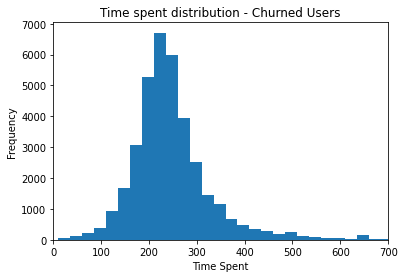

In [27]:
# Time Spent distribution - Churned Users
bin_edges = np.arange (10, time_churn_df['length'].max()+25, 25)
plt.hist(data = time_churn_df, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Time Spent')
plt.ylabel('Frequency')
plt.title('Time spent distribution - Churned Users')

Text(0.5, 1.0, 'Time spent distribution - Non Churned Users')

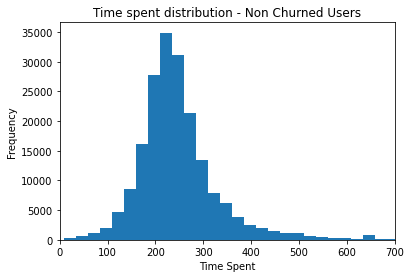

In [28]:
# Time Spent distribution - Non-Churned Users
bin_edges = np.arange (10, time_nonchurn_df['length'].max()+25, 25)
plt.hist(data = time_nonchurn_df, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Time Spent')
plt.ylabel('Frequency')
plt.title('Time spent distribution - Non Churned Users')

It seemed that there is no significant difference between these two groups in the length of time they spent. As a result, it will not help much in the churn prediction.

**Level - Compare between 2 groups**

In [29]:
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



Let's plot it to get a better visualization

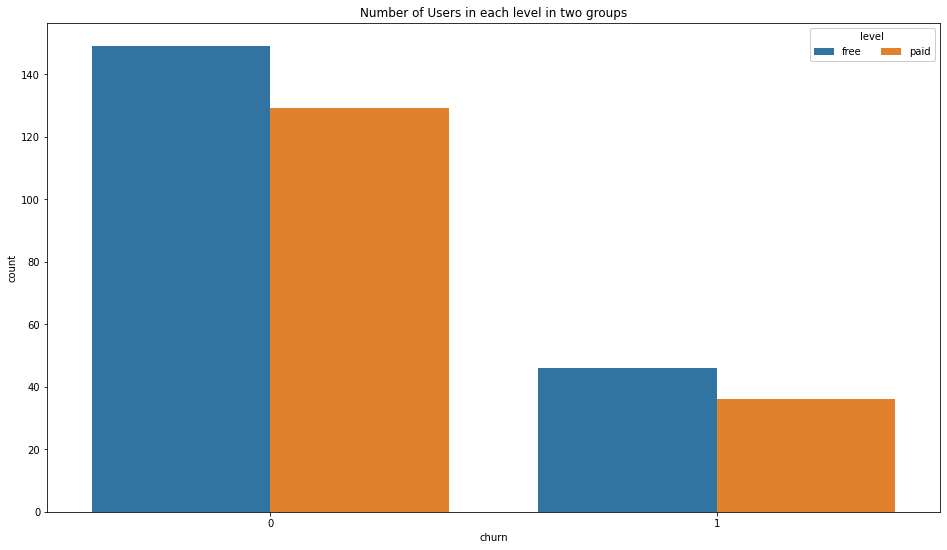

In [30]:
plt.figure(figsize = [16,9])
ax = sns.barplot(data = df_level.toPandas(), x = 'churn', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
plt.title("Number of Users in each level in two groups");


From the chart, there is a slightly difference between free users compare with the paid ones. Users who don't pay for the service have more people who churn than the users who pay.  
It's still not clear enough to perform churn prediction. I will do more expore in other features to find more interesting information then.

**Gender - Compare between 2 groups**

In [31]:
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender','churn').count()
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



Once again, for better visualization, let's plot it with Seaborn

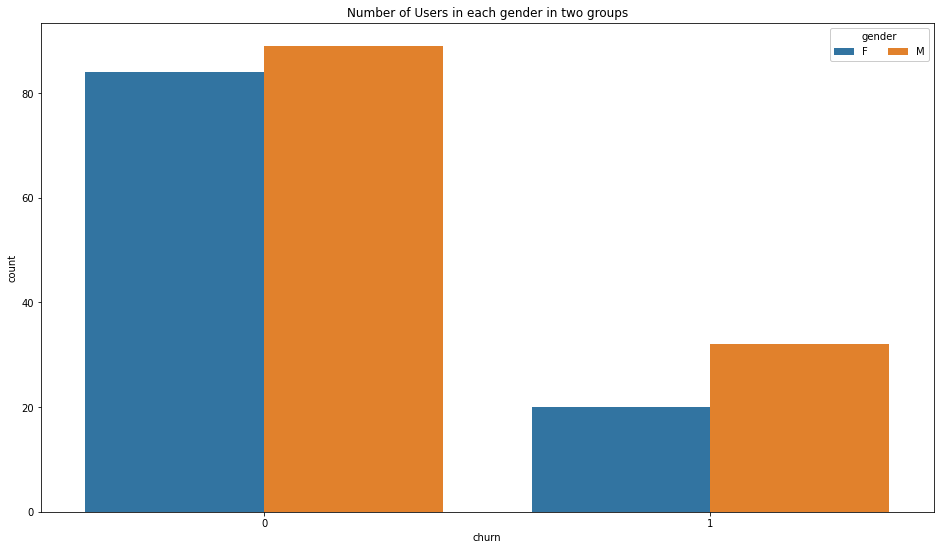

In [32]:
plt.figure(figsize = [16,9])
ax = sns.barplot(data = df_gender.toPandas(), x = 'churn', y='count', hue = 'gender')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Number of Users in each gender in two groups");

I can see that pretty much more male users are likely to churn compared to female users.

**Page Visited - Compare between 2 groups**

In [33]:
df_page = df.select(['userId', 'churn', 'page']).dropDuplicates().groupBy('page','churn').count()
df_page.show(10)

+--------------------+-----+-----+
|                page|churn|count|
+--------------------+-----+-----+
|            Settings|    0|  152|
|         Thumbs Down|    1|   48|
|           Thumbs Up|    1|   50|
|     Add to Playlist|    1|   50|
|               Error|    1|   22|
|               About|    1|   31|
|         Thumbs Down|    0|  155|
|         Roll Advert|    1|   50|
|                Home|    0|  172|
|Cancellation Conf...|    1|   52|
+--------------------+-----+-----+
only showing top 10 rows



In [34]:
page_churn_df = df_page.filter(df.churn==1).toPandas().sum()
page_nonchurn_df = df_page.filter(df.churn==0).toPandas().sum()

In [35]:
# calculate the rate of pages visited by those who churned vs. those who stayed
df_page = df_page.toPandas()
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/page_nonchurn_df['count'], np.where(
    df_page['churn'] == 1, df_page['count']/page_churn_df['count'],df_page['count']/page_churn_df['count'])) 

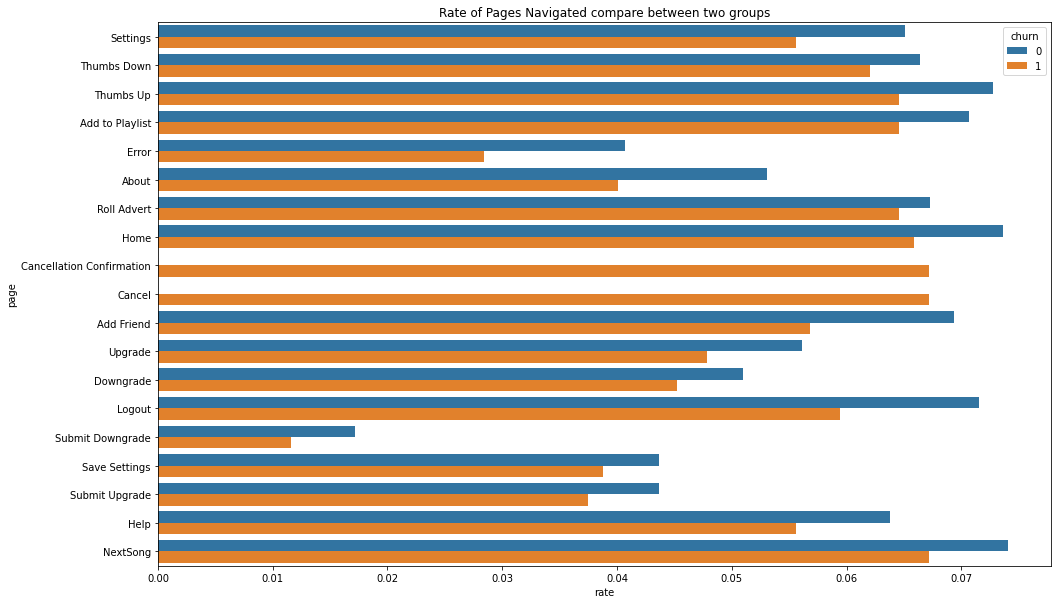

In [36]:
# plot the pages by churn
plt.figure(figsize=[16,10])
sns.barplot(data = df_page, x = 'rate', y = 'page', hue = 'churn')
plt.title('Rate of Pages Navigated compare between two groups');

We can observe from the above chart that skipping to the next song was the most common activity for both users who stayed and users who left. More thumbs up gestures, friends, and song additions were made by those who were more inclined to stay.

**Location - Compare between two groups**

In [37]:
df.select(['userId', 'churn', 'location']).groupBy('location').count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
|Allentown-Bethleh...|  815|
|Miami-Fort Lauder...| 3764|
|           Selma, AL| 2027|
+--------------------+-----+
only showing top 20 rows



We can extract te last two characters in `location` column, which is the state code to do this analysis

In [38]:
# Create an User Define Function to get the last two characters
get_state_code = udf(lambda x: x[-2:])

In [39]:
# Create a new column call 'state_code'
df_state = df.withColumn('state_code', get_state_code(df.location))
df_state.head()

Row(artist=None, auth='Logged In', firstName='Colin', gender='M', itemInSession=92, lastName='Larson', length=None, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='GET', page='Home', registration=1537982255000, sessionId=2428, song=None, status=200, ts=1543587349000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0', userId='100', churn=0, state_code='TX')

Use Seaborn to plot it

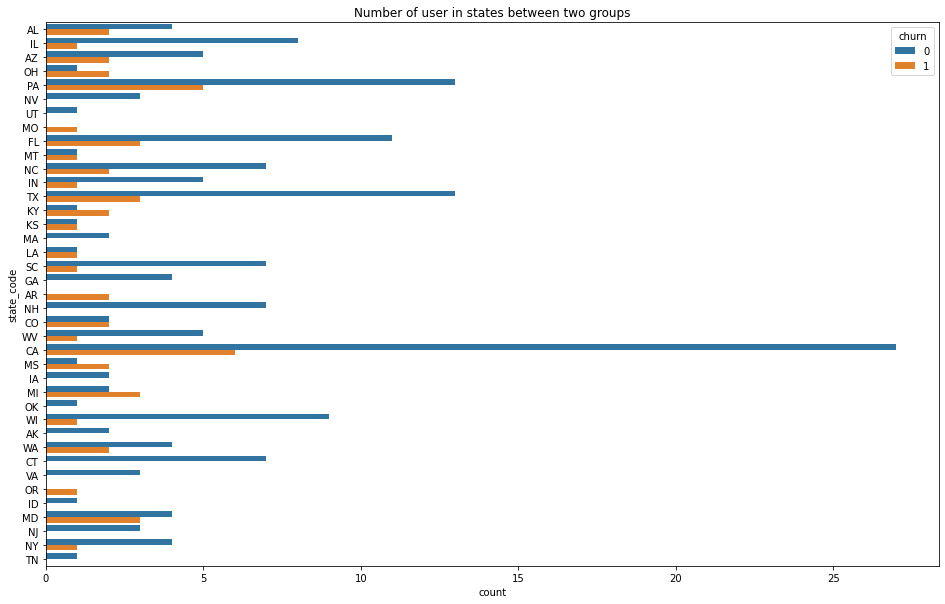

In [40]:
df_state = df_state.select("state_code", "userId", "churn").dropDuplicates().groupby("state_code", "churn").count()
plt.figure(figsize=[16,10])
sns.barplot(data = df_state.toPandas(), x = 'count', y = 'state_code', hue = 'churn')
plt.title('Number of user in states between two groups');

CA state experienced the most users. In the states of MI, KY, and OH, more users left than stayed. When it comes to modeling, it could be challenging to develop a helpful feature for this. Moving on to another column: `operating systems` and `browsers`.

**Browser and Operating System - Compare between 2 groups**

In [41]:
df_os = df.select("userId", "userAgent", "churn").dropDuplicates(['userId'])
df_os.show()

+------+--------------------+-----+
|userId|           userAgent|churn|
+------+--------------------+-----+
|   100|Mozilla/5.0 (Wind...|    0|
|100004|Mozilla/5.0 (comp...|    0|
|100005|"Mozilla/5.0 (Mac...|    1|
|100006|"Mozilla/5.0 (Win...|    1|
|100007|"Mozilla/5.0 (Win...|    1|
|100008|Mozilla/5.0 (Maci...|    0|
|100009|"Mozilla/5.0 (Win...|    1|
|100010|"Mozilla/5.0 (iPh...|    0|
|100014|"Mozilla/5.0 (Win...|    1|
|100015|"Mozilla/5.0 (Mac...|    1|
|100021|"Mozilla/5.0 (Mac...|    1|
|100022|Mozilla/5.0 (Maci...|    1|
|100025|"Mozilla/5.0 (Mac...|    1|
|   101|Mozilla/5.0 (Wind...|    1|
|   104|"Mozilla/5.0 (Win...|    0|
|   107|Mozilla/5.0 (Wind...|    0|
|    11|Mozilla/5.0 (Wind...|    0|
|   110|"Mozilla/5.0 (Mac...|    0|
|   112|Mozilla/5.0 (Wind...|    0|
|   113|"Mozilla/5.0 (Mac...|    0|
+------+--------------------+-----+
only showing top 20 rows



In [42]:
# Create a new column names 'os' 
os_list = ["Windows", "Mac", "Linux", "iPhone", "iPad"]
df_os = df_os.toPandas()
df_os['os'] = df_os.userAgent.str.extract('(?i)({0})'.format('|'.join(os_list)))

In [43]:
df_os.head()

,userId,userAgent,churn,os
0,100,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,0,Windows
1,100004,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,0,Windows
2,100005,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1,Mac
3,100006,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1,Windows
4,100007,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1,Windows


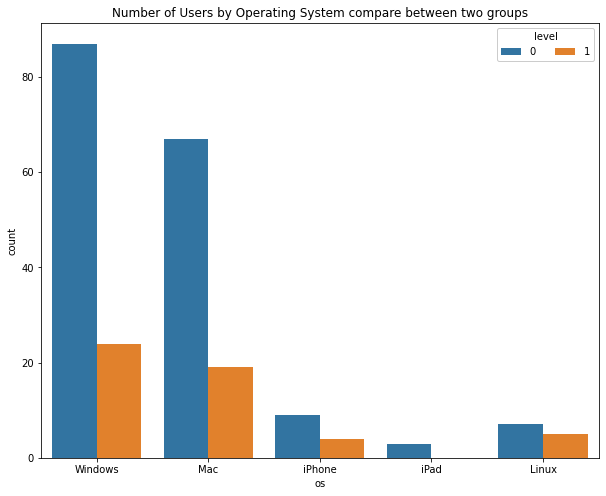

In [44]:
plt.figure(figsize=[10,8])
sns.countplot(data = df_os, x = 'os', hue ='churn')
plt.title('Number of Users by Operating System compare between two groups')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

We can observe that Windows and Mac are the two Operating System that have the most number of users.

I will analyze with the same process on browser information

In [45]:
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]
df_os['browser'] = df_os.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))

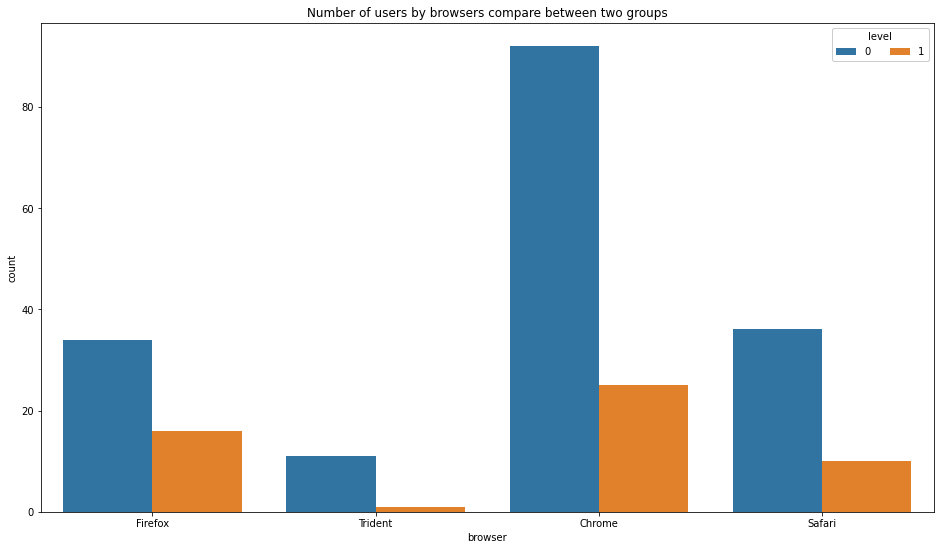

In [46]:
plt.figure(figsize=[16,9])
sns.countplot(data = df_os, x = 'browser', hue ='churn')
plt.title('Number of users by browsers compare between two groups')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

The most used browser was Chrome. Users using Firefox had the highest churned rate. The user churned rate was lowest for Trident. There isn't a glaring problem with browsers that is driving customers away. So, this won't be incorporated into our model.

# Feature Engineering
The features I will build out are:

- gender

- level

- number of songs per session

- number of rollads actions

- number of thumb down actions

- number of thumbs up actions

- number of friends added

- number of songs added to playlist

- account age

I'll combine these together and create a churn label as target. This will produce a dataFrame with each row containing details about a unique user. This dataframe may be vectorized, standardized, and fed into our various machine learning algorithms once the `userId` has been removed.

First I will convert categorical variables to numerical to prepare for our model.

**gender**

In [47]:
gender = df.select(['userId', 'gender']).dropDuplicates()
gender = gender.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))
gender.show(10)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|    39|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
+------+------+
only showing top 10 rows



**level**

In [48]:
level = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(desc("ts"))
level = level.withColumn("Rank", dense_rank().over(w))
level.show(10)

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
+------+-----+-------------+----+
only showing top 10 rows



In [49]:
level = level.filter(level.Rank == 1).drop(level.Rank)
level = level.drop('ts')
level = level.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))
level.show(20)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows



**average number of songs per session**

In [50]:
num_song_per_sess = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()
num_song_per_sess = num_song_per_sess.groupby('userId').agg({"count":"avg"})
num_song_per_sess = num_song_per_sess.withColumnRenamed("avg(count)", "avg_song")
num_song_per_sess.show(2)

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
+------+------------------+
only showing top 2 rows



**number of 'rollads' actions**

In [51]:
rollad = df.select(["userId", "page"])
rollad_flag = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
rollad = rollad.withColumn("rollad", rollad_flag("page"))
rollad = rollad.groupby('userId').sum("rollad")
rollad = rollad.withColumnRenamed("sum(rollad)", "roll_ad")
rollad.show(2)

+------+-------+
|userId|roll_ad|
+------+-------+
|   125|      1|
|    51|      0|
+------+-------+
only showing top 2 rows



**number of 'thumb down' actions**

In [52]:
thumbdown = df.select(["userId", "page"])
thumbdown_flag = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
thumbdown = thumbdown.withColumn("Thumbs Down", thumbdown_flag("page"))
thumbdown = thumbdown.groupby('userId').sum("Thumbs Down")
thumbdown = thumbdown.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")
thumbdown.show(5)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|   125|          0|
|    51|         21|
|   124|         41|
|     7|          1|
|    54|         29|
+------+-----------+
only showing top 5 rows



**number of 'thumb up' actions**

In [53]:
thumbup = df.select(["userId", "page"])
thumbup_flag = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
thumbup = thumbup.withColumn("Thumbs Up", thumbup_flag("page"))
thumbup = thumbup.groupby('userId').sum("Thumbs Up")
thumbup = thumbup.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")
thumbup.show(5)

+------+---------+
|userId|thumbs_up|
+------+---------+
|   125|        0|
|    51|      100|
|   124|      171|
|     7|        7|
|    54|      163|
+------+---------+
only showing top 5 rows



**number of friends added**

In [54]:
friend = df.select(["userId", "page"])
friend_flag = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
friend = friend.withColumn("add_friend", friend_flag("page"))
friend = friend.groupby('userId').sum("add_friend")
friend = friend.withColumnRenamed("sum(add_friend)", "add_friend")
friend.show(5)

+------+----------+
|userId|add_friend|
+------+----------+
|   125|         0|
|    51|        28|
|   124|        74|
|     7|         1|
|    54|        33|
+------+----------+
only showing top 5 rows



**number of songs added to playlist**

In [55]:
playlist = df.select(["userId", "page"])
song_add_flag = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
playlist = playlist.withColumn("Playlist", song_add_flag("page"))
playlist = playlist.groupby('userId').sum("Playlist")
playlist = playlist.withColumnRenamed("sum(Playlist)", "playlist")
playlist.show(2)

+------+--------+
|userId|playlist|
+------+--------+
|   125|       0|
|    51|      52|
+------+--------+
only showing top 2 rows



**account age**

In [56]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(desc("ts"))
df_days = df_days.withColumn("Rank", dense_rank().over(w))
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))
df_days = df_days.withColumn('age',(df_days['delta_days']/1000/3600/24))
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|               age|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [57]:
account_age = df_days.drop('registration', 'ts', 'churn', 'delta_days')
account_age.show()

+------+------------------+
|userId|               age|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
|100004|172.44008101851853|
|100005| 85.19559027777778|
|100006| 9.127164351851851|
|100007|115.38761574074074|
|100008| 68.22856481481482|
|100009| 37.43827546296296|
|100010|  55.6436574074074|
|100011| 5.165115740740741|
|100012| 43.05261574074074|
|100013| 44.17873842592593|
|100014| 85.08340277777778|
|100015| 67.87921296296297|
|100016| 75.01533564814815|
|100017| 78.88440972222223|
|100018|110.71211805555555|
+------+------------------+
only showing top 20 rows



**number of artists listened**

In [58]:
artists = df.select("userId", "artist").dropDuplicates().groupby("userId").count()
artists = artists.withColumnRenamed("count", "num_artists")
artists.show(2)


+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
+------+-----------+
only showing top 2 rows



**Label**

Now I create the label column indicating if the user churned (1) or not (0).


In [59]:
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()
label = label.drop('count')
label = label.withColumnRenamed("churn", "label")
label.show()

+------+-----+
|userId|label|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
|100004|    0|
|100005|    1|
|100006|    1|
|100007|    1|
|100008|    0|
|100009|    1|
|100010|    0|
|100011|    1|
|100012|    1|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    1|
|100018|    0|
+------+-----+
only showing top 20 rows



**Join features I created to get the final data for our model**

In [60]:
feature_df = gender.join(level, ["userId"])\
                    .join(num_song_per_sess, ["userId"])\
                    .join(rollad, ["userId"])\
                    .join(thumbdown, ["userId"])\
                    .join(thumbup, ["userId"])\
                    .join(friend, ["userId"])\
                    .join(playlist, ["userId"])\
                    .join(account_age, ["userId"])\
                    .join(artists, ['userId'])\
                    .join(label, ["userId"])
feature_df.show()

+------+------+-----+------------------+-------+-----------+---------+----------+--------+------------------+-----------+-----+
|userId|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|               age|num_artists|label|
+------+------+-----+------------------+-------+-----------+---------+----------+--------+------------------+-----------+-----+
|    10|     0|    1|112.16666666666667|      1|          4|       37|        12|       9| 51.76265046296297|        566|    0|
|   100|     0|    1| 78.88235294117646|     25|         27|      148|        49|      61| 64.87377314814815|       1706|    0|
|100001|     1|    0|             33.25|     14|          2|        8|         2|       3| 44.80021990740741|        126|    1|
|100002|     1|    1|             48.75|      3|          0|        5|         1|       5|160.47207175925925|        185|    0|
|100003|     1|    0|              25.5|      9|          0|        3|         0|       2|22.74811342592

**Drop `userId` column**

In [61]:
feature_df = feature_df.drop('userId')
feature_df.show()

+------+-----+------------------+-------+-----------+---------+----------+--------+------------------+-----------+-----+
|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|               age|num_artists|label|
+------+-----+------------------+-------+-----------+---------+----------+--------+------------------+-----------+-----+
|     0|    1|112.16666666666667|      1|          4|       37|        12|       9| 51.76265046296297|        566|    0|
|     0|    1| 78.88235294117646|     25|         27|      148|        49|      61| 64.87377314814815|       1706|    0|
|     1|    0|             33.25|     14|          2|        8|         2|       3| 44.80021990740741|        126|    1|
|     1|    1|             48.75|      3|          0|        5|         1|       5|160.47207175925925|        185|    0|
|     1|    0|              25.5|      9|          0|        3|         0|       2|22.748113425925926|         51|    1|
|     1|    1|              47.1

In [62]:
# Schema check
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- age: double (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- label: long (nullable = true)



Cast all columns to **float** data type

In [63]:
for feature in feature_df.columns:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))

In [64]:
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- age: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- label: float (nullable = true)



**Vector Assembler**  
Vector assembler's function is to convert our features into a vector. The vector may then be normalized and fed into the model of our choice.

In [65]:
assembler = VectorAssembler(inputCols = ['gender','level','avg_song','roll_ad','thumbs_down','thumbs_up','add_friend','playlist','age'], outputCol = "vec_features")
feature_df = assembler.transform(feature_df)
feature_df.show()

+------+-----+----------+-------+-----------+---------+----------+--------+---------+-----------+-----+--------------------+
|gender|level|  avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|      age|num_artists|label|        vec_features|
+------+-----+----------+-------+-----------+---------+----------+--------+---------+-----------+-----+--------------------+
|   0.0|  1.0|112.166664|    1.0|        4.0|     37.0|      12.0|     9.0| 51.76265|      566.0|  0.0|[0.0,1.0,112.1666...|
|   0.0|  1.0| 78.882355|   25.0|       27.0|    148.0|      49.0|    61.0| 64.87377|     1706.0|  0.0|[0.0,1.0,78.88235...|
|   1.0|  0.0|     33.25|   14.0|        2.0|      8.0|       2.0|     3.0| 44.80022|      126.0|  1.0|[1.0,0.0,33.25,14...|
|   1.0|  1.0|     48.75|    3.0|        0.0|      5.0|       1.0|     5.0|160.47208|      185.0|  0.0|[1.0,1.0,48.75,3....|
|   1.0|  0.0|      25.5|    9.0|        0.0|      3.0|       0.0|     2.0|22.748114|       51.0|  1.0|[1.0,0.0,25.5,9.0...|


**Normalization**  
I can standardize all the values now that we have our vectors. This is necessary for our machine learning model in order to make the individual features appear like typical regularly distributed data and to prevent the results from being dominated by the features with the highest values.

In [66]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)
scaler_model = scaler.fit(feature_df)
feature_df = scaler_model.transform(feature_df)
feature_df.head()

Row(gender=0.0, level=1.0, avg_song=112.16666412353516, roll_ad=1.0, thumbs_down=4.0, thumbs_up=37.0, add_friend=12.0, playlist=9.0, age=51.76264953613281, num_artists=566.0, label=0.0, vec_features=DenseVector([0.0, 1.0, 112.1667, 1.0, 4.0, 37.0, 12.0, 9.0, 51.7626]), features=DenseVector([0.0, 2.0844, 2.6321, 0.0464, 0.3059, 0.5651, 0.583, 0.2751, 1.3744]))

**Split dataset into train/test/val dataset**

In [67]:
feature_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



In [68]:
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2], seed = 1996)
print("Training Dataset Size:" + str(train.count()))
print("Test Dataset Size:" + str(test.count()))
print("Validation Dataset Size:" + str(valid.count()))

Training Dataset Size:133
Test Dataset Size:42
Validation Dataset Size:50


# Modeling
I have now perform feature engineering to create features_df and split the entire dataset into train, test, and validation sets using a dataframe with just numerical variables. I will evaluate several machine learning classification algorithms, such as:  
 - Logistic Regression  
 - Random Forest Classifier  
 - Naive Bayes  
Since churn prediction is a binary classification problem—meaning that users will either churn (1) or stay (0) in a certain length of time.  

## Metrics
I will evaluate the models' accuracy and adjust the parameters as appropriate. Based on test accuracy, we will ultimately choose our best model, and I will present the validation set findings. I will use F1 score as the metric to improve because the churned users are a very tiny fraction. F1, a metric for model accuracy on a dataset, is used to assess binary classification systems like the one I are evaluating here. F1-score is a method of integrating the model's precision and recall and provides a better assessment of the examples that were mistakenly categorized than accuracy metric. F1 is furthermore stronger at handling unbalanced classes like the ones I have.


#### Training and evaluating models

In [69]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=43)
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')

Define the evaluator. Here i am using is multiclassclassificationevaluator to get the F1 scores and create a model list containing all the instances of model created aboved to train in a for loop.


In [70]:
model_list = [lr,rf,nb]
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

For loop to fit models in the dataset and perform evaluation on the models

In [71]:
# for loop to go through all our models
for model in model_list:
    model_name = model.__class__.__name__
    print('='*100)
    print(f'Training session - MODEL NAME: {model_name}\n')
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended')
    print(f'Training session for {model_name} finished successfully!\n')
    print(f'Training time: {end-start} seconds')
    # evaluating
    predictions = model.transform(valid)
    print(f'EVALUATING REPORT FOR MODEL {model_name}')
    print('F1-score:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print(f"Accuracy: {accuracy}")
    print('='*100)

Training session - MODEL NAME: LogisticRegression

LogisticRegression training ended
Training session for LogisticRegression finished successfully!

Training time: 104.57204127311707 seconds
EVALUATING REPORT FOR MODEL LogisticRegression
F1-score: 0.8043650793650794
Accuracy: 0.8
Training session - MODEL NAME: RandomForestClassifier

RandomForestClassifier training ended
Training session for RandomForestClassifier finished successfully!

Training time: 140.30964422225952 seconds
EVALUATING REPORT FOR MODEL RandomForestClassifier
F1-score: 0.7942982456140351
Accuracy: 0.88
Training session - MODEL NAME: NaiveBayes

NaiveBayes training ended
Training session for NaiveBayes finished successfully!

Training time: 54.266648292541504 seconds
EVALUATING REPORT FOR MODEL NaiveBayes
F1-score: 0.6738870431893688
Accuracy: 0.78


# Conclusion

Here our RF model achieved accuracy of 0.88. In terms of data points, accuracy is the proportion of all predictions that were accurate. Thus, 88 of the 100 predictions we made were true, or 88% of them, for an accuracy of 0.88.  
The F1-Score of RF is 0.79. Here, F1 is a metric for assessing the model's performance on a dataset and is applied to binary classification systems like the one we have. F1-score is a method of integrating the model's precision and recall and provides a better assessment of the examples that were mistakenly categorized than accuracy metric. F1 is furthermore stronger at handling unbalanced classes like the ones we have.

# References

https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-apache-spark-2-4-5-and-pyspark-python  
https://spark.apache.org/docs/2.2.0/ml-classification-regression.html   
https://www.silect.is/blog/random-forest-models-in-spark-ml/   
https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221     
https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2
https://dhiraj-p-rai.medium.com/essentials-of-feature-engineering-in-pyspark-part-i-76a57680a85 
https://medium.com/bazaar-tech/apache-spark-data-cleaning-using-pyspark-for-beginners-eeeced351ebf
https://hackersandslackers.com/cleaning-pyspark-dataframes/
https://towardsdatascience.com/complete-introduction-to-pyspark-part-4-62a99ce3552a
https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html